# CO2_singleLSTM

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mini project/co2temp_data.csv')

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i) # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)
TRAIN_SPLIT = 200
uni_data = df['co2']
uni_data.index = df['date']
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT, univariate_past_history, univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None, univariate_past_history, univariate_future_target)

(32, 1)
Epoch 1/10
200/200 [==============================] - 4s 11ms/step - loss: 0.3459 - val_loss: 0.4682
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2603 - val_loss: 0.3708
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1467 - val_loss: 0.6094
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1208 - val_loss: 0.6144
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1063 - val_loss: 0.6247
Epoch 6/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0981 - val_loss: 0.5963
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0932 - val_loss: 0.5757
Epoch 8/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0895 - val_loss: 0.5597
Epoch 9/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0865 - val_loss: 0.5518
Epoch 10/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0841 - val_los

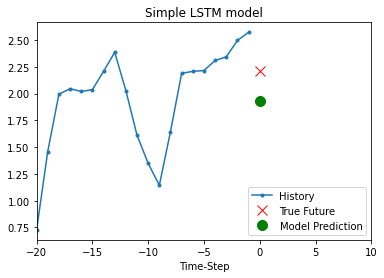

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()
simple_lstm_model = tf.keras.models.Sequential([
      # x_train_uni.shape = (299980, 20, 1)
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')
#모델의 출력을 확인하기 위해 샘플 예측을 만들어 봅니다
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)
for x, y in val_univariate.take(1):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()